In [1]:
import typing as tp
import os

import albumentations as albu
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torchvision
from albumentations.pytorch.transforms import ToTensorV2

from torch import nn, optim
from torch.utils.data import Dataset
from torchvision.models import efficientnet_b0
from torchsummary import summary
from tqdm.auto import tqdm


# Constants

In [2]:
IMG_H = 128
IMG_W = 128

CROP_H = int(IMG_H * 3 / 4)
CROP_W = int(IMG_W * 3 / 4)

CELEBA_DATA_PATH = "../data/raw/CelebA/img_align_celeba/"
MY_IMAGES_DATA_PATH = "../data/raw/my_images/"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


EMBEDDING_SIZE = 300
MARGIN = 1.0

N_ANCHOR_CLASSES = 10

BATCH_SIZE = 64
LR = 1e-3
MOMENTUM = 0.9

# Data preparation

## Augmentations

In [3]:
def pre_transform() -> albu.BasicTransform:
    return albu.Resize(IMG_H, IMG_W, always_apply=True)

In [4]:
def augmentation_transforms() -> albu.BaseCompose:
    result = [
        albu.GaussNoise(),
        albu.OneOf(
            [
                albu.MotionBlur(blur_limit=3, p=0.7),
                albu.MedianBlur(blur_limit=3, p=1.0),
                albu.Blur(blur_limit=3, p=0.7),
            ], 
            p=0.5
        ),
        albu.OneOf(
            [
                albu.RandomGamma(gamma_limit=(85, 115), p=0.5),
                albu.RandomBrightnessContrast(
                    brightness_limit=0.5,
                    contrast_limit=0.5,
                    p=0.5
                ),
                albu.CLAHE(clip_limit=2),
            ], 
            p=0.5
        ),
        albu.Rotate(
            limit=5,
            crop_border=True
        ),
        albu.HorizontalFlip(),
        albu.RandomResizedCrop(
            height=IMG_H,
            width=IMG_W,
            scale=(0.75, 0.75),
            always_apply=True
        )
    ]
    return albu.Compose(result)

In [5]:
def post_transform() -> albu.BaseCompose:
    return albu.Compose([
        albu.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0,
            always_apply=True
        ),
        ToTensorV2()
    ])

## Dataset

In [6]:
class CelebADataset(Dataset):
    def __init__(
        self,
        basic_transforms: albu.BaseCompose,
        data_path: str = CELEBA_DATA_PATH,
        data_type: str = "train",
        augmentation_transforms: tp.Optional[albu.BaseCompose] = None
    ) -> None:
        super().__init__()
        self.data_type = data_type
        self.data_path = data_path
        
        self.basic_transforms = basic_transforms
        self.augmentation_transforms = augmentation_transforms
        
        self.label2images_names = dict()
        self.label2count = dict()
        self.image_names = []
        self.labels = []
        
        self._initialize()
        self.num_of_classes = len(self.label2count.keys())
    
    def get_batch(
        self,
        n_way: int
    ) -> torch.Tensor:
        image_names = self._get_sample(n_way)
        
        images = torch.cat(
            [
                torch.cat(
                    [
                        self._get_image(anchor)[None, ...],
                        self._get_image(anchor)[None, ...],
                        self._get_image(negative)[None, ...],
                    ],
                    dim=0
                )[None, ...]
                for anchor, negative in image_names
            ],
            dim=0
        )
        
        return images
            
    def _initialize(self) -> None:
        number_of_images = 0
        with open(self.data_path + "labels.txt", "r") as f:
            number_of_images =  sum(1 for _ in f)
        
        with open(self.data_path + "labels.txt", "r") as file:
            for line in tqdm(file, desc="Reading images", total=number_of_images):
                img_name, img_label = line.split()
                img_label = int(img_label)

                if img_label not in self.label2images_names:
                    self.label2images_names[img_label] = [img_name]
                    self.label2count[img_label] = 1
                else:
                    self.label2images_names[img_label] += [img_name]
                    self.label2count[img_label] += 1
        
        for label in self.label2images_names.keys():
            for img_name in self.label2images_names[label]:
                self.image_names += [img_name]
                self.labels += [label]
    
    def _get_sample(
        self,
        n_anchor_classes: int
    ) -> np.ndarray:
        random_classes = np.random.choice(
            list(self.label2images_names.keys()), 
            size=n_anchor_classes * 2,
            replace=False
        )
        
        images_names = np.array([
            np.random.choice(
                self.label2images_names[random_classe], 
                size=1
            ).tolist()  for random_classe in random_classes
        ]).reshape(n_anchor_classes, 2).tolist()
        
        return images_names
    
    def _get_image(
        self,
        image_name: str
    ) -> torch.Tensor:
        img = cv2.imread(self.data_path + "images/" + image_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.augmentation_transforms is not None:
            img = self.augmentation_transforms(image=img)
        else:
            img = self.basic_transforms(image=img)
        
        return img["image"] 
    
    def __getitem__(self, index: int) -> tp.Tuple:
        img = self._get_image(
            image_name=self.image_names[index]
        )
            
        return (img, self.labels[index])
    
    def __len__(self):
        return len(self.image_names)

In [7]:
basic_transformation = albu.Compose([
    pre_transform(), post_transform()
])

augmentation_transformation = albu.Compose([
    pre_transform(), augmentation_transforms(), post_transform()
])

inference_transformation = albu.Compose([
    pre_transform(),
    ToTensorV2()
])

dataset = CelebADataset(
    basic_transforms=basic_transformation,
    augmentation_transforms=augmentation_transformation
)

Reading images:   0%|          | 0/202599 [00:00<?, ?it/s]

### Check weather augmentation works well

Время получения одной картинки

In [8]:
%%timeit
image_sample, label = dataset[0]

2.2 ms ± 91.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


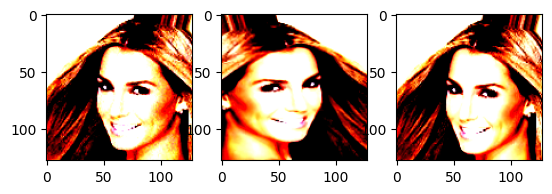

In [9]:
plt.subplot(131)
image_sample, label = dataset[0]
image1 = image_sample
plt.imshow(image1.permute(1, 2, 0))

plt.subplot(132)
image_sample, _ = dataset[0]
image1 = image_sample
plt.imshow(image1.permute(1, 2, 0))

plt.subplot(133)
image_sample, _ = dataset[0]
image1 = image_sample
plt.imshow(image1.permute(1, 2, 0))

Время получения батча картинок размером N_WAY

In [10]:
%%timeit
batch = dataset.get_batch(N_ANCHOR_CLASSES)

235 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


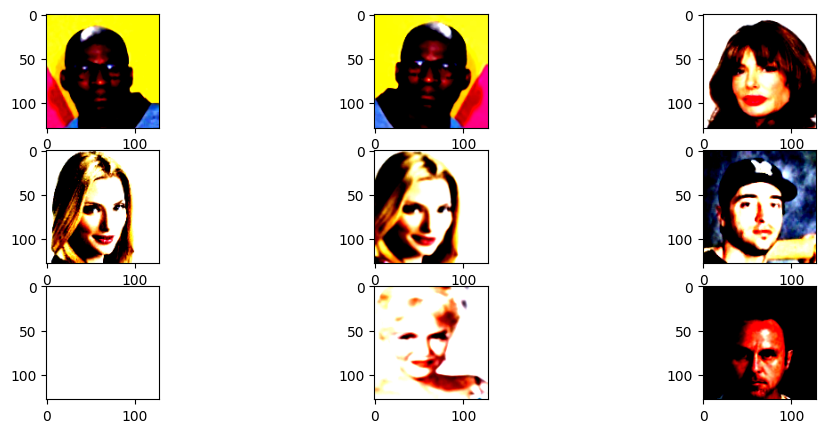

In [11]:
n = 3
m = 3
batch = dataset.get_batch(n)
fig, axis = plt.subplots(n, m, figsize=(12, 5))
for i in range(n):
    for j in range(m):
        axis[i, j].imshow(np.clip(batch[i, j].permute(1, 2, 0), 0, 1))

# Model

In [12]:
class EfficientNetModel(nn.Module):
    def __init__(
        self,
        embedding_size: int,
    ) -> None:
        super().__init__()
        self.model = efficientnet_b0(weights="IMAGENET1K_V1")
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=1280, out_features=embedding_size)
        )
    
    def set_model_requires_grad(self) -> None:
        for name, param in self.model.named_parameters():
            if name.split(".")[0] != "classifier":
                param.requires_grad = False
            else:
                param.requires_grad = True
    
    def set_model_to_train(self) -> None:
        self.model.eval()
        self.model.classifier.train()
        
    def get_trainable_params(self) -> tp.List:
        trainable_params = []
        for param in self.model.parameters():
            if param.requires_grad == True:
                trainable_params += [param]
        return trainable_params
    
    def forward(self, img):
        return self.model(img)

# Train

In [13]:
def train_epoch(
    model: nn.Module,
    train_dataset: CelebADataset,
    loss_func: nn.TripletMarginLoss,
    opt: torch.optim.SGD,
    session_size: int
) -> tp.Dict:
    history = {
        "loss": []
    }
    
    for _ in tqdm(range(session_size)):
        model.zero_grad()
        data = train_dataset.get_batch(N_ANCHOR_CLASSES).view(-1, 3, IMG_W, IMG_H).to(DEVICE)

        embeddings = model(data).view(N_ANCHOR_CLASSES, 3, EMBEDDING_SIZE)
        
        loss = loss_func(
            embeddings[:, 0],
            embeddings[:, 1],
            embeddings[:, 2]
        )
        
        history["loss"] += [loss.item()]
        loss.backward()
        opt.step()
        
    return history

In [14]:
def eval_epoch() -> None:
    pass

In [15]:
def train(
    model: nn.Module,
    train_dataset: CelebADataset,
    loss_func: nn.TripletMarginLoss,
    opt: torch.optim.SGD,
    scheduler: optim.lr_scheduler.StepLR,
    session_size: int,
    epoch_num: int=5
) -> tp.Dict:
    history = {
        "loss": []
    }
    
    for _ in range(epoch_num):
        epoch_hist = train_epoch(
            model,
            train_dataset,
            loss_func,
            opt,
            session_size
        )
        
        history["loss"].extend(epoch_hist["loss"])
        
        scheduler.step()
    
    return history

In [16]:
def eval() -> None:
    pass

In [17]:
model = EfficientNetModel(EMBEDDING_SIZE).to(DEVICE)
model.train()
opt = optim.SGD(model.get_trainable_params(), lr=LR, momentum=MOMENTUM)
scheduler = optim.lr_scheduler.StepLR(opt, 1, gamma=0.8, last_epoch=-1)

triplet_loss = nn.TripletMarginLoss(margin=MARGIN, p=2.0)

In [18]:
history = train(
    model=model,
    train_dataset=dataset,
    loss_func=triplet_loss,
    opt=opt,
    scheduler=scheduler,
    session_size=200,
    epoch_num=5
)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

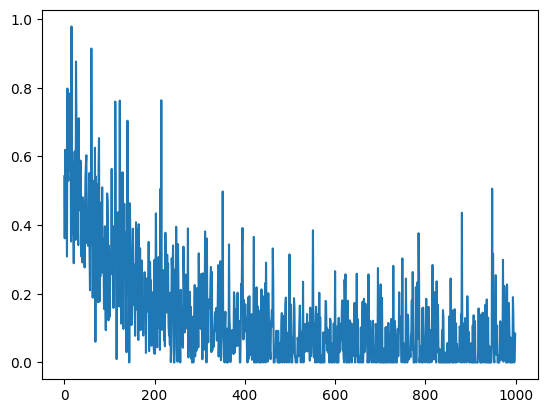

In [19]:
plt.plot(history["loss"])

# Inference

In [28]:
class FaceRec:
    def __init__(
        self,
        model: nn.Module,
        basic_transforms: albu.BaseCompose,
        augmentation_transforms: albu.BaseCompose
) -> None:
        self.model = model
        self.model.cpu().eval()
        self.basic_transforms = basic_transforms
        self.augmentation_transforms = augmentation_transforms
        self.emb_to_mean_num = 50
        self.margin = 0
        self.margin_std = 0
        
    def learn_owner(self, img: torch.Tensor) -> None:
        mean_embedding  = self.model(
            self.basic_transforms(image=img)["image"][None, ...]
        )
        
        for _ in range(self.emb_to_mean_num):
            mean_embedding += self.model(
                self.augmentation_transforms(image=img)["image"][None, ...]
            )
        
        self.owner_embeddings = mean_embedding / self.emb_to_mean_num
        
        margins = []
        for _ in range(self.emb_to_mean_num):
            margins += [
                torch.norm(
                    self.owner_embeddings - self.model(
                        self.augmentation_transforms(image=img)["image"][None, ...]
                    )
                ).detach().numpy()
            ]
        self.margin = np.mean(margins)
        self.margin_std = np.std(margins)
        
        
    def recognize_face(self, img: torch.Tensor) -> int:
        embedding = self.model(img)
        return torch.norm(self.owner_embeddings - embedding) < self.margin + MARGIN + 3 * self.margin_std
        

In [29]:
recognizer = FaceRecModel(
    model,
    basic_transformation,
    augmentation_transformation
)

In [22]:
my_faces = None
for image_name in os.listdir(MY_IMAGES_DATA_PATH):
    img = cv2.imread(MY_IMAGES_DATA_PATH + image_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = torch.tensor(img).permute(2, 0, 1)
    if my_faces is None: 
        my_faces = img[None, ...]
    else:
        my_faces = torch.cat(
            (my_faces, img[None, ...]),
            dim = 0
        )

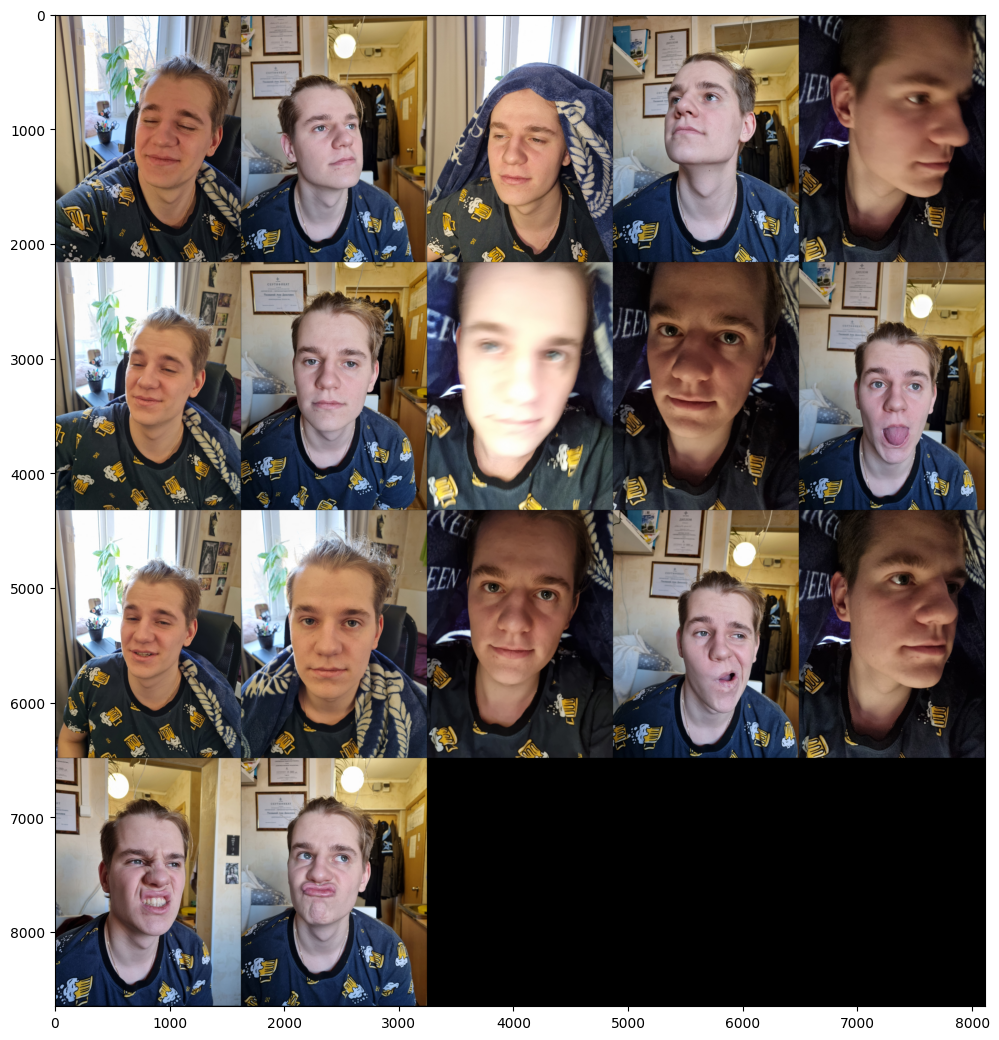

In [45]:
grid = torchvision.utils.make_grid(my_faces, nrow=5)
plt.figure(figsize=(12, 15))
plt.imshow(grid.permute(1, 2, 0))

In [39]:
recognizer.learn_owner(my_faces[0].permute(1, 2, 0).numpy())

In [40]:
answers_pos = []
for my_face_img in my_faces:
    ans_pos = recognizer.recognize_face(
        basic_transformation(
            image=my_face_img.permute(1, 2, 0).numpy()
        )["image"][None, ...]
    )
    answers_pos += [ans_pos]
    
    
answers_neg = []
for _ in range(100):
    image_sample, _ = dataset[np.random.randint(len(dataset))]

    answers_neg += [
        int(recognizer.recognize_face(image_sample[None, ...]))
    ]

In [41]:
print("Accuracy on POS samples:", sum(answers_pos) / len(answers_pos))
print("Accuracy on NEG samples:", 1 - sum(answers_neg) / len(answers_neg))

Accuracy on POS samples: tensor(0.8235)
Accuracy on NEG samples: 0.88
